In [1]:
# ============================================================
# Traffic Data EDA – Using Sampled Dataset
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
pd.set_option("display.max_columns", None)

# ------------------------------------------------------------
# 1. Load the dataset
# ------------------------------------------------------------
traffic_path = r"C:\Users\aasth\Downloads\Traffic_Sample.csv"
traffic = pd.read_csv(traffic_path)

# Remove any 'Unnamed' columns
traffic = traffic.loc[:, ~traffic.columns.str.contains('^Unnamed', case=False)]

print("✅ Dataset loaded successfully.")
print("Shape:", traffic.shape)
print("Columns:", list(traffic.columns))
traffic.head()


✅ Dataset loaded successfully.
Shape: (52429, 20)
Columns: ['DAY', 'DATE', 'FAC', 'LANE', 'TIME', 'TOTAL', 'CASH', 'EZPASS', 'VIOLATION', 'LANEMODE', 'Month', 'Facility', 'Autos', 'Small_T', 'Large_T', 'Buses', 'Year', 'FAC_G', 'FAC_G2', 'Day_Name']


,DAY,DATE,FAC,LANE,TIME,TOTAL,CASH,EZPASS,VIOLATION,LANEMODE,Month,Facility,Autos,Small_T,Large_T,Buses,Year,FAC_G,FAC_G2,Day_Name
0,3,1/1/2014,7,6,2300,147,0,142,5,D,1,GWB Upper,130,1,16,0,2014,GWB,GWB,Wednesday
1,6,5/17/2025,6,10,1600,415,68,328,19,D,5,Outerbridge,412,3,0,0,2025,SIB,Outerbridge,Saturday
2,6,3/15/2014,1,3,2200,216,51,160,5,D,3,Holland,214,1,0,1,2014,Tunnels,Holland,Saturday
3,1,11/4/2024,1,8,700,652,123,501,28,D,11,Holland,585,63,0,4,2024,Tunnels,Holland,Monday
4,1,10/28/2013,1,1,800,315,100,212,3,M,10,Holland,292,7,0,16,2013,Tunnels,Holland,Monday


In [2]:
# ------------------------------------------------------------
# Normalize FACILITY column and parse DATE column
# ------------------------------------------------------------

# Some files used 'FAC' instead of 'FACILITY' → unify the column
if "FACILITY" not in traffic.columns:
    possible_fac = [col for col in traffic.columns if "FAC" in col.upper()]
    if possible_fac:
        traffic["FACILITY"] = traffic[possible_fac[0]]

# Convert DATE column to proper datetime (if it exists)
if "DATE" in traffic.columns:
    traffic["DATE"] = pd.to_datetime(traffic["DATE"], errors="coerce")

print("✅ Facility column standardized and dates parsed.")



✅ Facility column standardized and dates parsed.


In [3]:
# ------------------------------------------------------------
# Null values and zero-length strings per column
# ------------------------------------------------------------
print("🔍 Null values per column:\n")
print(traffic.isnull().sum())

# Initialize dict for zero-length strings
zero_len = {}

# Check for empty strings in object (string-like) columns
for col in traffic.columns:
    if traffic[col].dtype == "object":
        zero_len[col] = (
            traffic[col].astype(str).str.strip().replace("nan", "").str.len() == 0
        ).sum()

# Convert dict to Series for pretty display
zero_len_series = pd.Series(zero_len).sort_values(ascending=False)

print("\n🔍 Zero-length strings per column:\n")
print(zero_len_series)


🔍 Null values per column:

DAY          0
DATE         0
FAC          0
LANE         0
TIME         0
TOTAL        0
CASH         0
EZPASS       0
VIOLATION    0
LANEMODE     0
Month        0
Facility     0
Autos        0
Small_T      0
Large_T      0
Buses        0
Year         0
FAC_G        0
FAC_G2       0
Day_Name     0
FACILITY     0
dtype: int64

🔍 Zero-length strings per column:

LANEMODE    0
Facility    0
FAC_G       0
FAC_G2      0
Day_Name    0
dtype: int64


In [4]:
# ------------------------------------------------------------
# Distinct values, text cleanup, and duplicate detection
# ------------------------------------------------------------

# Count distinct (unique) values in each column
print("\n🔍 Distinct values per column:\n")
print(traffic.nunique().sort_values(ascending=False))

# Strip leading/trailing spaces from all string columns
for col in traffic.select_dtypes(include="object").columns:
    # Convert to string (in case of mixed types) and strip spaces
    traffic[col] = traffic[col].astype(str).str.strip()

print("\n✅ Leading and trailing spaces removed from text columns.")

# Check and report duplicate rows
duplicates = traffic.duplicated().sum()
print(f"\n🔍 Duplicate rows detected: {duplicates}")

# Optionally drop duplicates (uncomment if you want to remove them)
# if duplicates > 0:
#     traffic = traffic.drop_duplicates().reset_index(drop=True)
#     print(f"✅ Removed {duplicates} duplicate rows.")




🔍 Distinct values per column:

TOTAL        1468
Autos        1450
EZPASS       1245
DATE          969
CASH          356
Buses         338
Large_T       289
Small_T       243
VIOLATION     121
LANE           36
TIME           24
Month          12
Year           10
FACILITY        8
FAC             8
Facility        8
DAY             7
Day_Name        7
FAC_G2          6
FAC_G           3
LANEMODE        2
dtype: int64

✅ Leading and trailing spaces removed from text columns.

🔍 Duplicate rows detected: 0


In [54]:
def detect_outliers(df, col):
    if pd.api.types.is_numeric_dtype(df[col]):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        return len(outliers), lower, upper
    return (0, None, None)

outlier_summary = {}
for col in traffic.select_dtypes(include=np.number).columns:
    c, l, u = detect_outliers(traffic, col)
    outlier_summary[col] = {"Outliers": c, "Lower": l, "Upper": u}

pd.DataFrame(outlier_summary).T


,Outliers,Lower,Upper
DAY,0.0,-4.0,12.0
FAC,0.0,-5.5,14.5
LANE,155172.0,-15.0,41.0
TIME,0.0,-1200.0,3600.0
TOTAL,74871.0,-282.0,694.0
CASH,25692.0,-111.0,185.0
EZPASS,57289.0,-355.0,693.0
VIOLATION,83921.0,-14.0,26.0
MONTH,0.0,-6.0,18.0
AUTOS,78608.0,-265.0,631.0


In [5]:
# ------------------------------------------------------------
# Descriptive Statistics (Mean, Median, and Standard Deviation)
# ------------------------------------------------------------

stats_summary = (
    traffic.describe()
           .T[["mean", "50%", "std"]]
           .rename(columns={"50%": "median"})
           .round(2)
)

print("\n📊 Descriptive Statistics Summary:\n")
display(stats_summary)  # works well in Jupyter





📊 Descriptive Statistics Summary:



,mean,median,std
DAY,3.976292,4.0,2.010015
DATE,2015-11-27 05:10:36.586621696,2013-12-19 00:00:00,NaN
FAC,5.155448,6.0,2.75643
LANE,17.990139,10.0,19.806785
TIME,1168.483091,1200.0,678.446718
TOTAL,255.7287,183.0,256.068073
CASH,41.61136,5.0,57.543612
EZPASS,205.612428,110.0,233.181814
VIOLATION,8.50556,4.0,11.97163
Month,5.561846,5.0,3.342885


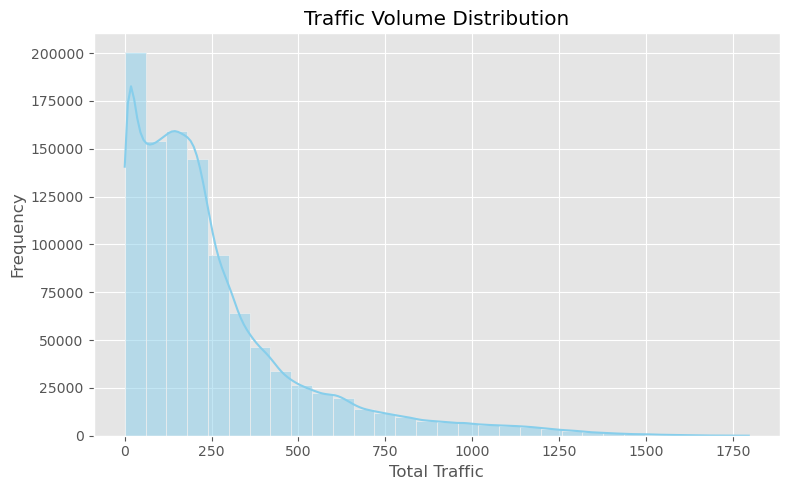

In [56]:
if "TOTAL" in traffic.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(traffic["TOTAL"], bins=30, kde=True, color="skyblue")
    plt.title("Traffic Volume Distribution")
    plt.xlabel("Total Traffic")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


C:\Users\aasth\AppData\Local\Temp\ipykernel_8176\2215572838.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


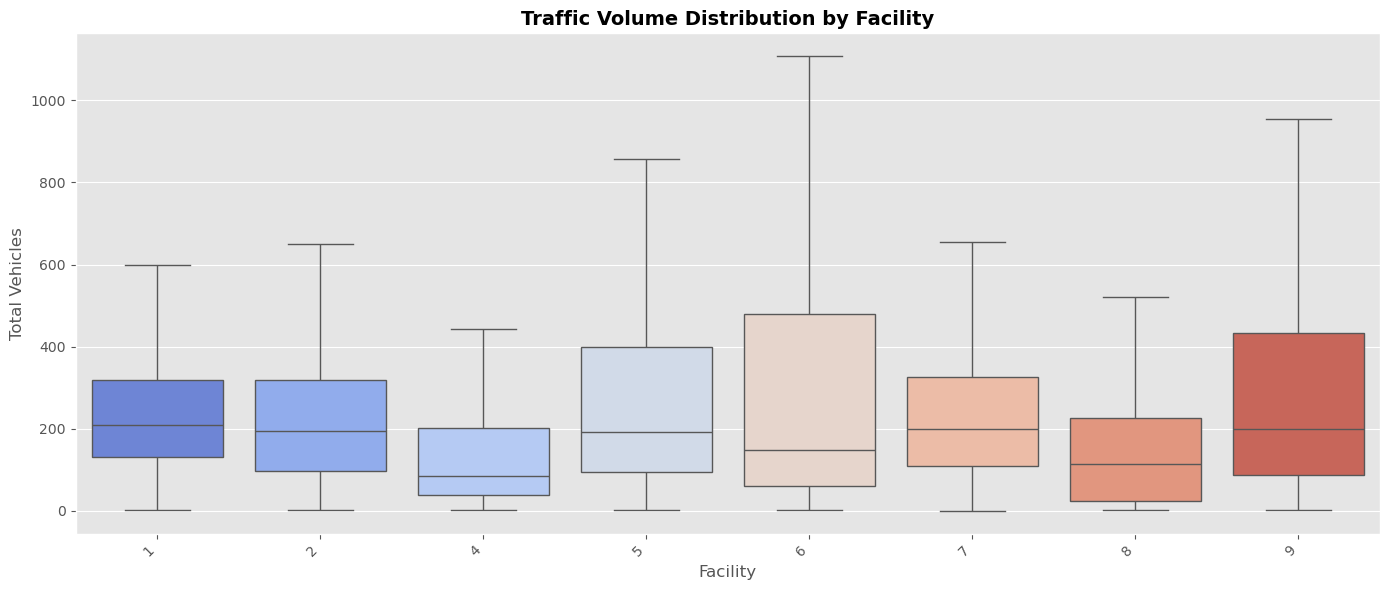

In [6]:
# ------------------------------------------------------------
# Box Plot – Traffic Volume by Facility
# ------------------------------------------------------------
if "FACILITY" in traffic.columns and "TOTAL" in traffic.columns:
    plt.figure(figsize=(14, 6))

    sns.boxplot(
        x="FACILITY",
        y="TOTAL",
        data=traffic,
        showfliers=False,   # hide extreme outliers to improve readability
        palette="coolwarm"
    )

    plt.title("Traffic Volume Distribution by Facility", fontsize=14, fontweight="bold")
    plt.xlabel("Facility", fontsize=12)
    plt.ylabel("Total Vehicles", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Columns FACILITY or TOTAL not found in dataset.")




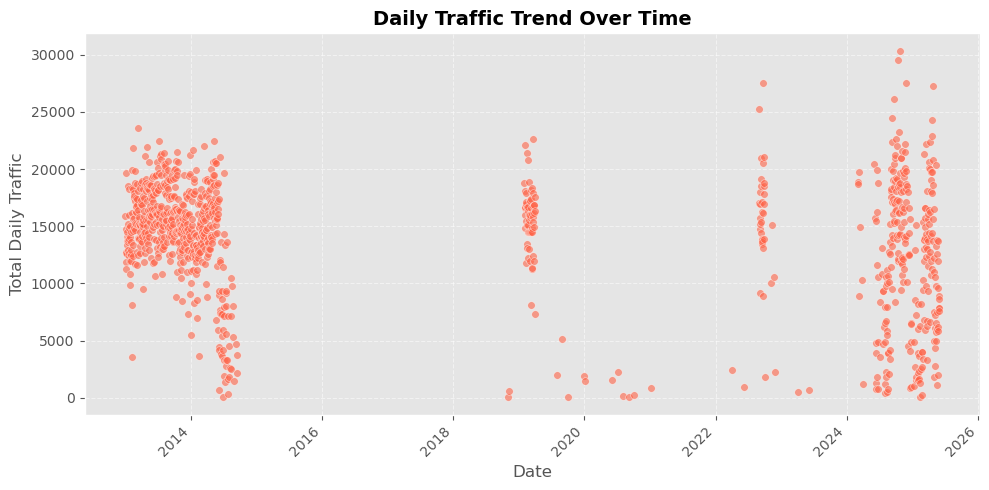

In [7]:
# ------------------------------------------------------------
# Scatter Plot – Daily Traffic Trend Over Time
# ------------------------------------------------------------
if "DATE" in traffic.columns and "TOTAL" in traffic.columns:
    # Ensure DATE column is parsed as datetime
    traffic["DATE"] = pd.to_datetime(traffic["DATE"], errors="coerce")

    # Aggregate total traffic per day (ignores missing/NaT)
    daily_traffic = (
        traffic.dropna(subset=["DATE"])
               .groupby("DATE", as_index=False)["TOTAL"]
               .sum()
               .sort_values("DATE")
    )

    # Plot the trend
    plt.figure(figsize=(10, 5))
    sns.scatterplot(
        x="DATE",
        y="TOTAL",
        data=daily_traffic,
        color="tomato",
        alpha=0.6,
        s=30
    )
    plt.title("Daily Traffic Trend Over Time", fontsize=14, fontweight="bold")
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Total Daily Traffic", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Columns 'DATE' or 'TOTAL' not found in dataset.")





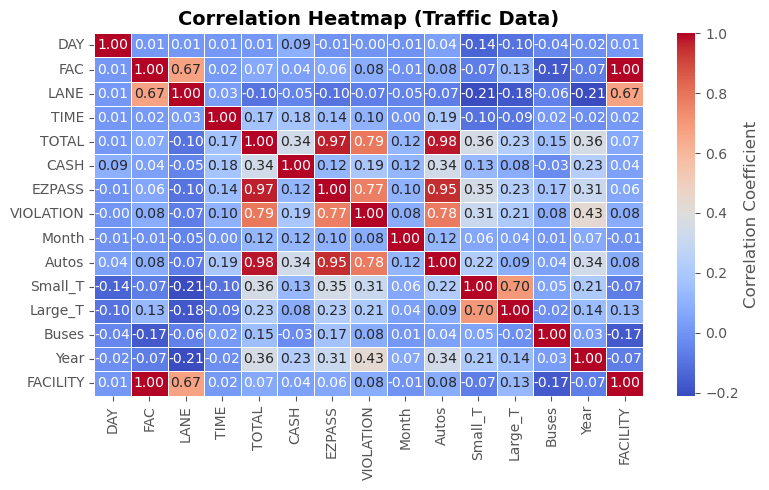

In [8]:
# ------------------------------------------------------------
# Correlation Heatmap for Numeric Columns
# ------------------------------------------------------------
num_cols = traffic.select_dtypes(include=[np.number])

if not num_cols.empty:
    corr_matrix = num_cols.corr().round(2)

    plt.figure(figsize=(8, 5))
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={'label': 'Correlation Coefficient'}
    )

    plt.title("Correlation Heatmap (Traffic Data)", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No numeric columns found for correlation analysis.")




In [9]:
# ------------------------------------------------------------
# Final EDA Summary
# ------------------------------------------------------------
print("✅ EDA Completed Successfully.")
print(f"Total Records: {len(traffic):,}")  # comma formatting for readability

# Facility Count
if 'FACILITY' in traffic.columns:
    print(f"Unique Facilities: {traffic['FACILITY'].nunique()}")
else:
    print("Unique Facilities: N/A")

# Date Range (formatted)
if 'DATE' in traffic.columns:
    date_min = pd.to_datetime(traffic['DATE'], errors='coerce').min()
    date_max = pd.to_datetime(traffic['DATE'], errors='coerce').max()
    if pd.notna(date_min) and pd.notna(date_max):
        print(f"Date Range: {date_min.strftime('%Y-%m-%d')} → {date_max.strftime('%Y-%m-%d')}")
    else:
        print("Date Range: N/A (invalid or missing dates)")
else:
    print("Date Range: N/A (DATE column not found)")




✅ EDA Completed Successfully.
Total Records: 52,429
Unique Facilities: 8
Date Range: 2013-01-01 → 2025-05-31
